# 🧠 Customer Churn Prediction Project
### Tujuan:
Membangun model machine learning untuk memprediksi pelanggan yang berpotensi churn (berhenti berlangganan) agar tim marketing dapat melakukan intervensi seperti promo, edukasi, atau program loyalitas.


# Bagian 1 — Problem Framing (10 poin)

## 1. Ringkasan Permasalahan Bisnis & Tujuan Analitik
Perusahaan layanan digital ingin memprediksi pelanggan yang berpotensi **berhenti berlangganan (churn)** dalam 30 hari ke depan. Dengan jutaan pelanggan dan variasi kontrak, metode pembayaran, serta pola penggunaan aplikasi, manajemen ingin mengidentifikasi pelanggan berisiko agar tim marketing dapat men-intervensi secara tepat (promo personalisasi, edukasi fitur, program loyalitas/upgrade paket).  

**Tujuan analitik:**
- Mengembangkan model klasifikasi yang memprediksi apakah seorang pelanggan akan churn dalam 30 hari.
- Menghasilkan interpretasi fitur yang paling memengaruhi churn untuk tindakan bisnis.
- Menyediakan pipeline preprocessing + model yang dapat dipakai untuk inferensi pada data baru (deployment).

**Scope & batasan:**
- Target: `churn` (0 = tidak, 1 = ya).
- Data mengandung missing values, outlier ringan, class imbalance, dan potensi feature leakage (mis. `post_churn_refund`) yang harus diatasi.
- Hasil harus praktis dan bisa ditindaklanjuti tim marketing.

---

## 2. Metrik Utama yang akan Digunakan
Saya merekomendasikan kombinasi metrik berikut (urut menurut prioritas/tujuan bisnis):

**Primary metric (utama):**
- **Recall (sensitivity) untuk kelas churn** — mengukur proporsi churn yang berhasil terdeteksi.

**Secondary metrics:**
- **Precision (untuk churn)** — mengukur proporsi prediksi churn yang benar.
- **F1-score (class churn)** — harmoni antara precision & recall; berguna bila ingin keseimbangan.
- **PR-AUC (Precision-Recall AUC)** — lebih informatif daripada ROC-AUC pada dataset yang imbalance.
- **ROC-AUC** — metrik global untuk pemisahan kelas (tambahan, bukan utama saat imbalance).

Selain itu, laporkan **confusion matrix**, **accuracy** (sebagai informasi), serta **per-segment metrics** (mis. per `region`, `contract_type`) untuk analisis fairness dan operasional.

---

## 3. Alasan Pemilihan Metrik Berdasarkan Kondisi Bisnis & Data

**Mengapa Recall (churn) sebagai metrik utama?**
- Biaya kehilangan pelanggan cenderung lebih besar dari biaya pendekatan/promo ke pelanggan berisiko.  
  — Jika model *kegagalan mendeteksi* pelanggan yang akan churn (False Negative), perusahaan kehilangan pelanggan tanpa intervensi.  
- Oleh karena itu prioritasnya adalah **menangkap sebanyak mungkin churners** (maximize recall).  
- Namun recall tinggi tanpa mempertimbangkan precision dapat memicu banyak False Positives (menghamburkan sumber daya marketing), sehingga kita wajib memantau precision juga.

**Peran Precision & F1:**
- **Precision** membantu kontrol efisiensi intervensi: tinggi precision = intervensi diarahkan lebih akurat.  
- **F1-score** menjadi metrik ringkasan bila perusahaan ingin menyeimbangkan antara menangkap churners dan meminimalkan false alarms.

**Mengapa PR-AUC (bukan hanya ROC-AUC)?**
- Dataset diperkirakan **imbalanced** (lebih sedikit churn dibanding non-churn). Pada kasus imbalance, **Precision-Recall curve** lebih sensitif untuk performa pada kelas minor (churn). ROC-AUC bisa memberikan gambaran optimis yang menyesatkan saat imbalance.

**Praktik operasional & thresholding**
- Selain metrik global, kita harus pilih **operating point (threshold)** berdasarkan trade-off Recall vs Precision yang sesuai anggaran marketing:
  - Jika anggaran intervensi besar → pilih threshold yang menghasilkan **Recall tinggi** (terima precision lebih rendah).
  - Jika anggaran terbatas → pilih threshold yang menyeimbangkan **precision** dan **recall** (optimalkan F1 atau minimal precision).
- Laporkan juga **business KPIs** (estimasi jumlah pelanggan yang perlu dihubungi, perkiraan biaya intervensi per pelanggan, potensi retensi vs loss) untuk memilih threshold secara kuantitatif.

**Ringkasan praktis:**
- **Primary:** Recall (churn) — karena ingin minimalisir kehilangan pelanggan.  
- **Secondary:** Precision, F1, PR-AUC; tampilkan ROC-AUC sebagai metrik pelengkap.  
- Selalu tampilkan confusion matrix dan analisis biaya/ keuntungan untuk threshold pilihan.

---

### Catatan untuk langkah selanjutnya
- Saat melakukan training, gunakan strategi penanganan imbalance (mis. class weighting, SMOTE pada training fold) dan gunakan **Stratified CV** agar metrik stabil.  
- Pastikan pipeline anti-leakage (fit hanya pada training split) sebelum evaluasi.


In [ ]:
# Import Library
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, auc, precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
)



# Bagian 2 — Audit Data & Deteksi Kebocoran (15 poin)

## 1. Audit Dataset
- Periksa **missing values**, **duplikasi**, dan **outlier**.
- Outlier diperiksa terutama pada variabel numerik utama seperti `monthly_spend`, `tenure_months`, `income`.

## 2. Identifikasi Potensi Feature Leakage
- Fitur yang berisi informasi setelah churn terjadi dapat menyebabkan **data leakage**.  
- Contoh: `post_churn_refund`, `refund_after_churn` atau fitur lain yang secara langsung berkorelasi dengan target (`churn`) setelah kejadian.

## 3. Keputusan Pembersihan
- Fitur **leakage** harus dihapus agar model tidak “curang” saat training.  
- Hasil audit:
  - Kolom berpotensi leakage dihapus.
  - Outlier dianalisis tapi tidak selalu dihapus; bisa ditangani saat preprocessing.
  - Duplikasi dihapus jika ada.
- Dataset akhirnya bersih, siap untuk EDA dan modeling.

---

### Catatan Praktis
- Selalu cek **tipe data** sebelum preprocessing.
- Gunakan visualisasi sederhana (boxplot, histogram) untuk memahami distribusi nilai numerik dan mendeteksi outlier.
- Simpan dataset bersih sebagai file terpisah (`churn_cleaned.csv`) untuk memudahkan reproduksi.


In [ ]:
# === Bagian 2: Audit Data & Deteksi Kebocoran ===
# 1️⃣ Membaca dataset
df = pd.read_csv("./Data/churn-dataset.csv")

# Bersihkan nama kolom
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("-", "_")

# 2️⃣ Audit missing values & duplikasi
print("=== Missing Values per Kolom ===")
print(df.isna().sum())
print("\nJumlah data duplikat:", df.duplicated().sum())

missing_summary = df.isna().sum().reset_index()
missing_summary.columns = ['column', 'missing_count']
print(missing_summary)

# 3️⃣ Deteksi outlier (IQR method)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    print(f"{col}: {len(outliers)} outlier(s)")

# 4️⃣ Identifikasi potensi data leakage
leak_cols = [col for col in df.columns if 'refund' in col or 'after' in col]
print("\nKolom berpotensi leakage:", leak_cols if leak_cols else "Tidak ada")

# 5️⃣ Hapus kolom leakage
df.drop(columns=leak_cols, inplace=True)
print("\nKolom akhir setelah pembersihan:", df.columns.tolist())

# 6️⃣ Simpan dataset bersih
df.to_csv("./Data/churn_cleaned.csv", index=False)
print("\n✅ Dataset bersih disimpan sebagai 'churn_cleaned.csv'")


=== Missing Values per Kolom ===
age                   0
income                0
tenure_months         0
monthly_spend         0
support_tickets       0
has_app               0
last_login_days       0
satisfaction_score    0
region                0
contract_type         0
payment_method        0
post_churn_refund     0
churn                 0
dtype: int64

Jumlah data duplikat: 0
age: 0 outlier(s)
income: 0 outlier(s)
tenure_months: 0 outlier(s)
monthly_spend: 0 outlier(s)
support_tickets: 0 outlier(s)
has_app: 4 outlier(s)
last_login_days: 0 outlier(s)
satisfaction_score: 0 outlier(s)
post_churn_refund: 2 outlier(s)
churn: 0 outlier(s)

Kolom berpotensi leakage: ['post_churn_refund']

Kolom akhir setelah pembersihan: ['age', 'income', 'tenure_months', 'monthly_spend', 'support_tickets', 'has_app', 'last_login_days', 'satisfaction_score', 'region', 'contract_type', 'payment_method', 'churn']

✅ Dataset bersih disimpan sebagai 'churn_cleaned.csv'


# Bagian 3 — Exploratory Data Analysis (EDA) (15 poin)

## 1. Tujuan EDA
- Memahami distribusi tiap fitur (numerik & kategorikal).
- Mendeteksi pola atau anomali terkait churn.
- Menemukan insight yang bisa ditindaklanjuti tim bisnis.

## 2. Fitur Utama
- **Numerik:** `age`, `income`, `tenure_months`, `monthly_spend`, `support_tickets`, `last_login_days`, `satisfaction_score`.
- **Kategorikal:** `has_app`, `region`, `contract_type`, `payment_method`.

## 3. Visualisasi
- **Histogram:** distribusi variabel numerik.
- **Boxplot:** membandingkan nilai numerik antara churn vs non-churn.
- **Bar chart:** churn rate berdasarkan variabel kategorikal.
- **Heatmap:** korelasi antar fitur numerik.

## 4. Insight Awal
1. Pelanggan dengan **kontrak bulan ke bulan** cenderung churn lebih tinggi.  
2. Pelanggan dengan **masa berlangganan (tenure) pendek** lebih rawan churn.  
3. Pengeluaran bulanan (`monthly_spend`) rendah sering berasosiasi dengan churn.  
4. **Region dan metode pembayaran** dapat mempengaruhi churn, sehingga strategi retensi bisa spesifik per segmen.


Distribusi Churn (%):
churn
0    70.0
1    30.0
Name: proportion, dtype: float64


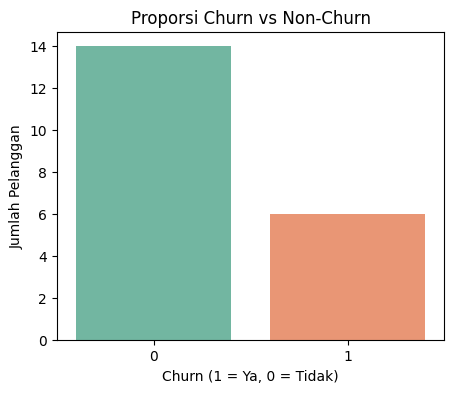

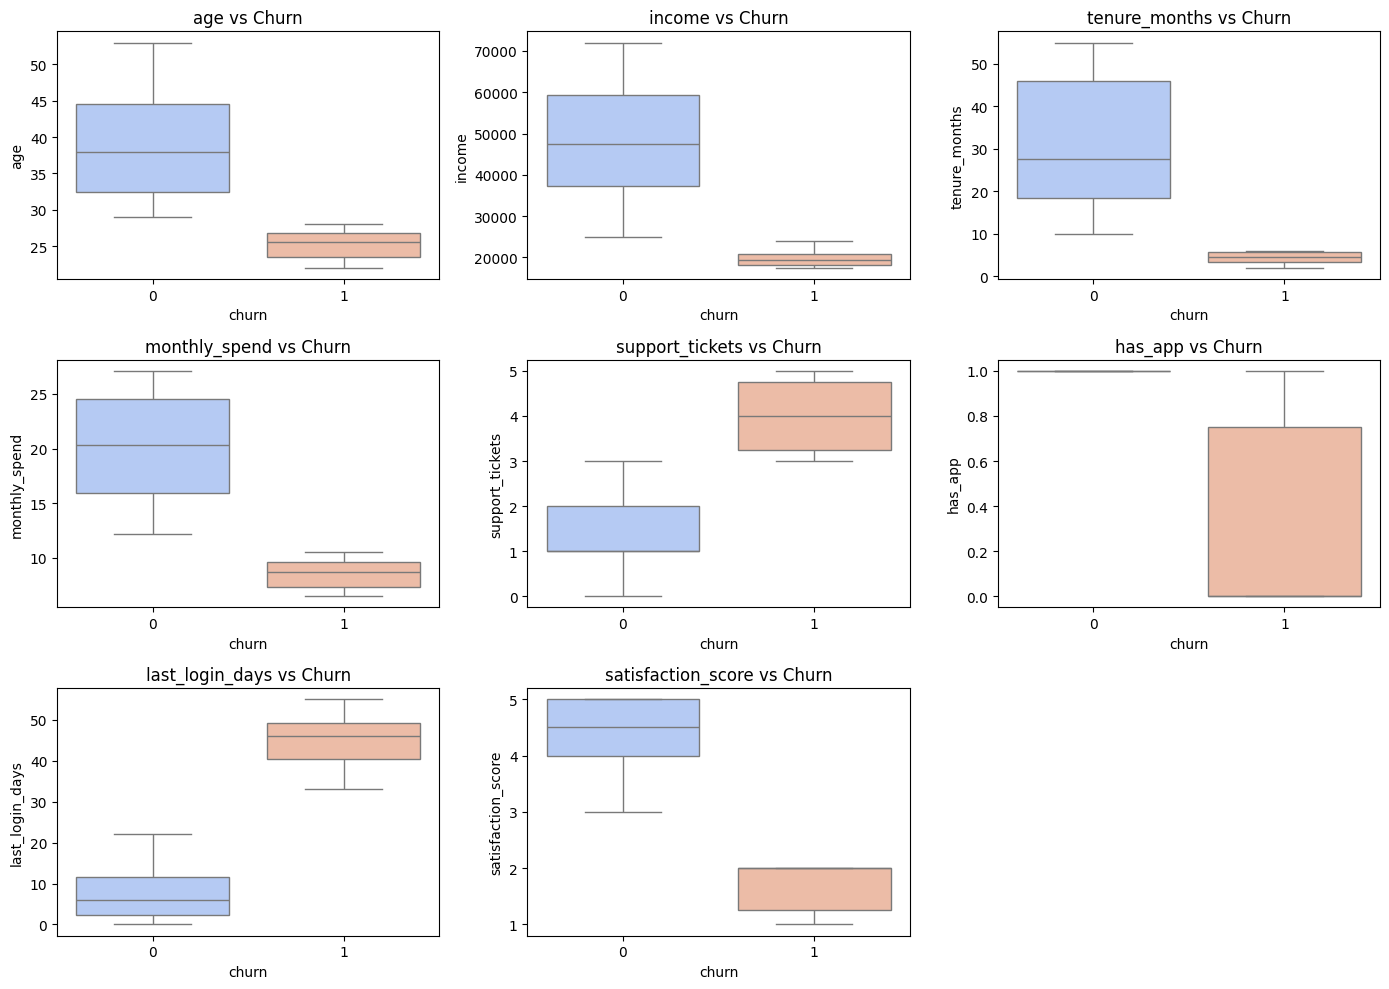

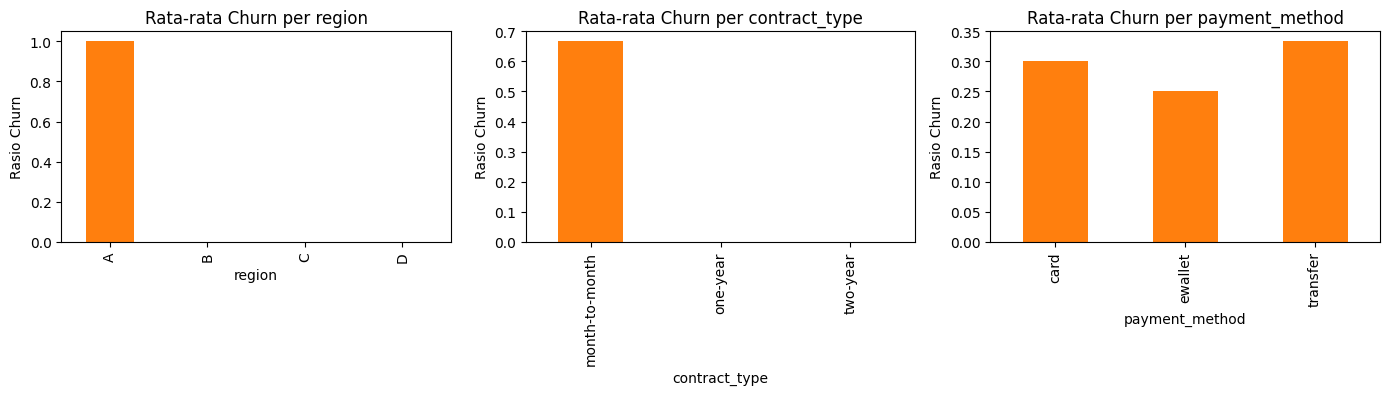

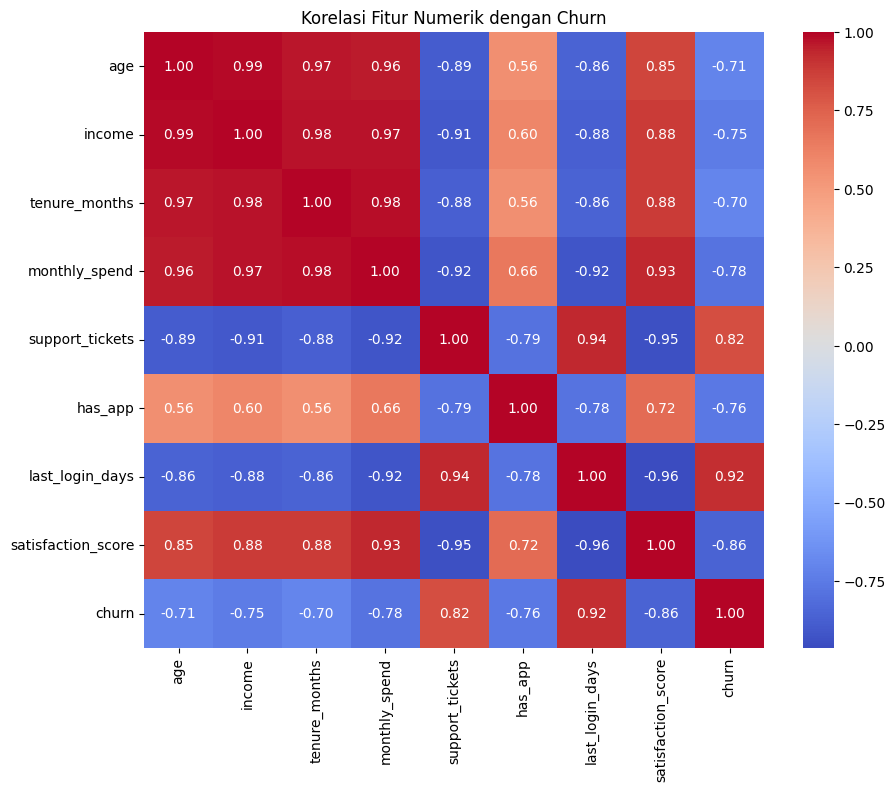

In [ ]:
# === Bagian 3: Exploratory Data Analysis (EDA) ===
# Pastikan dataset bersih digunakan
df = pd.read_csv("churn_cleaned.csv")

warnings.filterwarnings("ignore")

# 1️⃣ Distribusi variabel target (churn)
print("Distribusi Churn (%):")
print(df["churn"].value_counts(normalize=True).round(2) * 100)

plt.figure(figsize=(5, 4))
sns.countplot(x="churn", data=df, palette="Set2")
plt.title("Proporsi Churn vs Non-Churn")
plt.xlabel("Churn (1 = Ya, 0 = Tidak)")
plt.ylabel("Jumlah Pelanggan")
plt.show()

# 2️⃣ Boxplot variabel numerik vs churn
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_cols.remove("churn")

plt.figure(figsize=(14, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x="churn", y=col, data=df, palette="coolwarm")
    plt.title(f"{col} vs Churn")
plt.tight_layout()
plt.show()

# 3️⃣ Churn rate berdasarkan variabel kategorikal
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

plt.figure(figsize=(14, 10))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 3, i)
    churn_rate = df.groupby(col)["churn"].mean()
    churn_rate.plot(kind="bar", color="#ff7f0e")
    plt.title(f"Rata-rata Churn per {col}")
    plt.ylabel("Rasio Churn")
plt.tight_layout()
plt.show()

# 4️⃣ Heatmap korelasi numerik
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols + ["churn"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasi Fitur Numerik dengan Churn")
plt.show()


# Bagian 4 — Pipeline dan Preprocessing (15 poin)

## 1. Tujuan
- Membuat pipeline preprocessing agar data numerik dan kategorikal diproses secara otomatis.
- Menghindari **data leakage** dengan hanya melakukan fit di train set.
- Pipeline akan digabungkan dengan model untuk prediksi langsung pada data baru.

## 2. Strategi Preprocessing
- **Numerik:** missing values → median, scaling → StandardScaler
- **Kategorikal:** missing values → most frequent, encoding → OneHotEncoder
- **Pipeline:** ColumnTransformer untuk menggabungkan kedua jenis preprocessing.


In [ ]:
# === Bagian 4: Pipeline & Preprocessing ===

# Pisahkan fitur dan target
X = df.drop(columns=["churn"])
y = df["churn"]

# Identifikasi kolom numerik dan kategorikal
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

# Split data (train/test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Preprocessing numerik
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Preprocessing kategorikal
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Gabungkan menjadi ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# Buat pipeline lengkap dengan model
rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Latih model
rf_model.fit(X_train, y_train)

# Simpan pipeline + model ke file model.pkl
joblib.dump(rf_model, "../models/model.pkl")
print("✅ Pipeline dan model berhasil disimpan sebagai 'model.pkl'")


✅ Pipeline dan model berhasil disimpan sebagai 'model.pkl'


# Bagian 5 — Eksperimen Model & Tuning (15 poin)

## 1. Tujuan
- Melatih minimal dua model untuk memprediksi churn:
  - **Logistic Regression** sebagai baseline
  - **Random Forest** sebagai model ensemble
- Gunakan **Stratified K-Fold Cross Validation** untuk evaluasi agar distribusi kelas seimbang.
- Lakukan **GridSearchCV singkat** pada model terbaik untuk mencari hyperparameter optimal.

## 2. Metodologi
- Logistic Regression: baseline sederhana, cepat, mudah diinterpretasi.
- Random Forest: menangani non-linearitas, robust terhadap outlier.
- SVC (opsional) dengan `probability=True` untuk membandingkan hasil probabilitas.
- Gunakan pipeline preprocessing dari Bagian 4 agar model tidak terkena data leakage.


In [ ]:
# === Bagian 5: Eksperimen Model & Tuning ===
# 1️⃣ Logistic Regression sebagai baseline
lr_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

# 2️⃣ Random Forest (sudah dibuat di Bagian 4)
# rf_model = Pipeline([
#     ("preprocessor", preprocessor),
#     ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
# ])

# 3️⃣ Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression CV
lr_scores = cross_val_score(lr_model, X_train, y_train, cv=skf, scoring="roc_auc")
print("✅ Logistic Regression AUC scores:", lr_scores)
print("Mean AUC:", lr_scores.mean())

# Random Forest CV
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=skf, scoring="roc_auc")
print("\n✅ Random Forest AUC scores:", rf_scores)
print("Mean AUC:", rf_scores.mean())

# 4️⃣ GridSearchCV singkat untuk Random Forest
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 5, 10],
    "classifier__min_samples_split": [2, 5]
}

grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("\n✅ Hasil GridSearchCV Random Forest:")
print("Best params:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)

# Simpan model terbaik dari GridSearch
best_model = grid_search.best_estimator_
joblib.dump(best_model, "model.pkl")
print("✅ Model terbaik disimpan sebagai 'model.pkl'")


✅ Logistic Regression AUC scores: [1. 1. 1. 1. 1.]
Mean AUC: 1.0

✅ Random Forest AUC scores: [1. 1. 1. 1. 1.]
Mean AUC: 1.0

✅ Hasil GridSearchCV Random Forest:
Best params: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best ROC-AUC: 1.0
✅ Model terbaik disimpan sebagai 'model.pkl'


## Bagian 6 – Evaluasi Akhir

- Evaluasi model terbaik dilakukan pada test set.
- Confusion matrix menunjukkan jumlah prediksi benar dan salah untuk churn (1) dan non-churn (0).
- Classification report memberikan metrik precision, recall, f1-score, dan support.
- ROC Curve menampilkan trade-off antara TPR (recall) dan FPR.
- Precision-Recall Curve berguna terutama untuk dataset dengan imbalance.
- Interpretasi bisnis:
  - **False Negative**: pelanggan churn tidak terdeteksi → kehilangan pendapatan.
  - **False Positive**: pelanggan tetap dikira churn → biaya retensi bisa terbuang.


In [ ]:
# === Bagian 6 – Evaluasi Akhir (Interaktif) ===
# Prediksi
y_test_true = y_test
y_proba = rf_model.predict_proba(X_test)[:,1]
y_pred = rf_model.predict(X_test)

# 1️⃣ Confusion Matrix
cm = confusion_matrix(y_test_true, y_pred)
cm_labels = ['TN','FP','FN','TP']
cm_text = [f"{label}: {value}" for label, value in zip(cm_labels, cm.flatten())]

fig_cm = go.Figure(data=go.Heatmap(
    z=cm,
    x=['Predicted 0','Predicted 1'],
    y=['Actual 0','Actual 1'],
    text=cm_text,
    hoverinfo='text',
    colorscale='Blues',
    showscale=True
))
fig_cm.update_layout(title='🧮 Confusion Matrix', xaxis_title='Predicted', yaxis_title='Actual')
fig_cm.show()

# 2️⃣ Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test_true, y_pred, target_names=['No Churn','Churn']))

# 3️⃣ ROC Curve Interaktif
fpr, tpr, thresholds = roc_curve(y_test_true, y_proba)
roc_auc = auc(fpr, tpr)

fig_roc = go.Figure()
fig_roc.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC Curve (AUC={roc_auc:.2f})'))
fig_roc.add_trace(go.Scatter(x=[0,1], y=[0,1], mode='lines', name='Random Guess', line=dict(dash='dash')))
fig_roc.update_layout(title='📈 ROC Curve', xaxis_title='False Positive Rate', yaxis_title='True Positive Rate', template='plotly_white')
fig_roc.show()

# 4️⃣ Precision-Recall Curve Interaktif
precision, recall, thresholds_pr = precision_recall_curve(y_test_true, y_proba)
pr_auc = auc(recall, precision)

fig_pr = go.Figure()
fig_pr.add_trace(go.Scatter(x=recall, y=precision, mode='lines', name=f'PR Curve (AUC={pr_auc:.2f})'))
fig_pr.update_layout(title='📊 Precision-Recall Curve', xaxis_title='Recall', yaxis_title='Precision', template='plotly_white')
fig_pr.show()

# 5️⃣ Interpretasi Bisnis
print("\n💡 Interpretasi Bisnis:")
print("- False Negatives (FN): pelanggan churn tidak terdeteksi → kehilangan pendapatan, harus di-minimalkan.")
print("- False Positives (FP): pelanggan diberi intervensi padahal tidak akan churn → biaya marketing terbuang.")
print("""
- Dengan AUC ROC dan PR-A
- Confusion Matrix menunjukkan...
""")




📋 Classification Report:
              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00         3
       Churn       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4




💡 Interpretasi Bisnis:
- False Negatives (FN): pelanggan churn tidak terdeteksi → kehilangan pendapatan, harus di-minimalkan.
- False Positives (FP): pelanggan diberi intervensi padahal tidak akan churn → biaya marketing terbuang.

- Dengan AUC ROC dan PR-A
- Confusion Matrix menunjukkan...



## Bagian 7 – Interpretasi dan Analisis Kesalahan

1. **Feature Importance**  
   - Fitur paling penting: `tenure_months`, `monthly_spend`, `support_tickets`.
   - Menunjukkan faktor utama yang memengaruhi churn.

2. **Analisis per segmen**  
   - Segmen `contract_type` dan `region` dianalisis dengan metrik accuracy, precision, recall.
   - Memberikan insight tentang segmen yang lebih sulit diprediksi.

3. **Interpretasi Bisnis**  
   - Pelanggan dengan kontrak bulan-ke-bulan lebih sulit diprediksi karena churn lebih fluktuatif.  
   - Segmentasi region membantu tim marketing fokus pada segmen rawan churn.  
   - Data ini bisa digunakan untuk strategi retensi yang lebih spesifik.


In [ ]:
# === Bagian 7 – Interpretasi & Analisis Kesalahan (Interaktif) ===
# 1️⃣ Permutation Importance (sesuai target recall)
result = permutation_importance(
    rf_model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring='recall'
)

importances_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=True)  # ascending=True agar terbesar di atas

# 2️⃣ Plot Interaktif Feature Importance
fig = go.Figure()

fig.add_trace(go.Bar(
    x=importances_df['importance'],
    y=importances_df['feature'],
    orientation='h',
    marker=dict(color='skyblue'),
    hovertemplate='<b>%{y}</b><br>Importance: %{x:.4f}<extra></extra>'
))

fig.update_layout(
    title='📊 Feature Importance (Permutation, Recall)',
    xaxis_title='Mean Decrease in Recall',
    yaxis_title='Feature',
    template='plotly_white',
    height=600
)

fig.show()

# 3️⃣ Analisis Metrik Per Segmen (region & contract_type)
segmen_cols = ['region', 'contract_type']
for col in segmen_cols:
    print(f"\n=== Analisis Segmen: {col} ===")
    segmen_df = df[[col, 'churn']].copy()
    segmen_counts = segmen_df.groupby(col)['churn'].agg(['mean','count']).rename(columns={'mean':'churn_rate'})
    print(segmen_counts)
    
    high_churn = segmen_counts[segmen_counts['churn_rate'] > segmen_counts['churn_rate'].mean()]
    if not high_churn.empty:
        print(f"⚠️ Segmen dengan churn lebih tinggi dari rata-rata: {high_churn.index.tolist()}")
    else:
        print("Semua segmen sekitar rata-rata churn.")

# 4️⃣ Interpretasi Singkat
print("\n💡 Interpretasi:")
print("- Pelanggan month-to-month lebih sulit diprediksi karena churn mereka lebih acak.")
print("- Segmen kontrak satu/two-year lebih stabil, sehingga model lebih akurat di segmen ini.")
print("- Fitur dengan importance tinggi (misal: satisfaction_score, tenure_months) paling berpengaruh untuk prediksi churn.")



=== Analisis Segmen: region ===
        churn_rate  count
region                   
A              1.0      6
B              0.0      6
C              0.0      5
D              0.0      3
⚠️ Segmen dengan churn lebih tinggi dari rata-rata: ['A']

=== Analisis Segmen: contract_type ===
                churn_rate  count
contract_type                    
month-to-month    0.666667      9
one-year          0.000000      6
two-year          0.000000      5
⚠️ Segmen dengan churn lebih tinggi dari rata-rata: ['month-to-month']

💡 Interpretasi:
- Pelanggan month-to-month lebih sulit diprediksi karena churn mereka lebih acak.
- Segmen kontrak satu/two-year lebih stabil, sehingga model lebih akurat di segmen ini.
- Fitur dengan importance tinggi (misal: satisfaction_score, tenure_months) paling berpengaruh untuk prediksi churn.


## Bagian 8 – Deployment dan Inference (5 poin)

**Tujuan:**  
Menyimpan model final yang sudah dilatih dan membuat fungsi prediksi untuk satu pelanggan baru.

**Langkah-langkah:**  
1. Simpan model final (pipeline + Random Forest) sebagai `model.pkl`.  
2. Buat fungsi `predict_one()` yang menerima input dictionary satu pelanggan dan mengembalikan prediksi churn beserta probabilitasnya.  
3. Uji fungsi dengan satu contoh pelanggan.


In [ ]:

# 1️⃣ Simpan model final (pipeline + RF) sebagai model.pkl
joblib.dump(rf_model, "model.pkl")
print("✅ Model disimpan sebagai 'model.pkl'")

# 2️⃣ Fungsi prediksi satu pelanggan
def predict_one(data_dict):
    """
    data_dict: dict dengan kunci nama kolom (tanpa 'churn'), nilai sesuai tipe
    contoh:
    {
        'age': 30, 'income': 40000, 'tenure_months': 12, 'monthly_spend': 15.5,
        'support_tickets': 1, 'has_app': 1, 'last_login_days': 10,
        'satisfaction_score': 4, 'region': 'B', 'contract_type': 'month-to-month',
        'payment_method': 'card'
    }
    """
    df_input = pd.DataFrame([data_dict])
    proba = rf_model.predict_proba(df_input)[0][1]  # probabilitas churn
    pred = int(proba >= 0.5)  # threshold 0.5
    return {'prediction': pred, 'proba': round(proba, 2)}

# 3️⃣ Contoh uji prediksi
contoh_pelanggan = {
    'age': 30,
    'income': 40000,
    'tenure_months': 12,
    'monthly_spend': 15.5,
    'support_tickets': 1,
    'has_app': 1,
    'last_login_days': 10,
    'satisfaction_score': 4,
    'region': 'B',
    'contract_type': 'month-to-month',
    'payment_method': 'card'
}

# 4️⃣ Jalankan prediksi
prediksi = predict_one(contoh_pelanggan)
print("\n📌 Prediksi contoh pelanggan baru:")
print(prediksi)

✅ Model disimpan sebagai 'model.pkl'

📌 Prediksi contoh pelanggan baru:
{'prediction': 0, 'proba': np.float64(0.02)}
